In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

df = pd.read_csv("data/nba_players_stats_2.csv") 

In [ ]:
df.TEAM_ID

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,...,Rank,Player,Pos,Team,Reason,Games Missed,Days Missed,Cash Total Per Days Missed,mapped_name,Total_Days_Missed
0,1630639,A.J. Lawson,A.J.,1610612742,DAL,23.0,42,27,15,0.643,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
1,1631260,AJ Green,AJ,1610612749,MIL,24.0,56,35,21,0.625,...,347.0,AJ Green,SG,MIL,"Nose, Illness, Ankle",4.0,"7 1/3-1/4, 3/24-3/25, 4/12-4/14",76510.0,AJ Green,7
2,1631100,AJ Griffin,AJ,1610612737,ATL,20.0,20,8,12,0.400,...,160.0,A.J. Griffin,SF,ATL,"Illness, Personal, Ankle",25.0,"56 11/21-11/21, 12/13-12/29, 2/12-2/23, 3/17-4/11",1194984.0,AJ Griffin,56
3,203932,Aaron Gordon,Aaron,1610612743,DEN,28.0,73,49,24,0.671,...,124.0,Aaron Gordon,PF,DEN,"Heel, Face, Foot",9.0,"16 11/26-12/1, 12/28-12/31, 3/25-3/26, 4/6-4/9",1955504.0,Aaron Gordon,16
4,1628988,Aaron Holiday,Aaron,1610612745,HOU,27.0,78,39,39,0.500,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0


In [10]:
pd.set_option('display.max_rows', None)

# Basic shape
df.shape

# Peek at data
df.head()

# Summary
df.info()

# Missing values
df.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2785 entries, 0 to 2784
Columns: 159 entries, PLAYER_ID to Total_Days_Missed
dtypes: float64(46), int64(98), object(15)
memory usage: 3.4+ MB


Player                        742
mapped_name                   742
Cash Total Per Days Missed    742
Days Missed                   742
Reason                        742
Team                          742
Pos                           742
Rank                          742
EXP                             2
HEIGHT                          2
WEIGHT                          2
POSITION                        2
FGA_adv                         0
PACE                            0
PACE_PER40                      0
sp_work_PACE                    0
PIE                             0
POSS                            0
FGM_adv                         0
PLAYER_ID                       0
FGM_PG                          0
FGA_PG                          0
FG_PCT_adv                      0
GP_RANK_adv                     0
W_RANK_adv                      0
E_USG_PCT                       0
L_RANK_adv                      0
E_PACE                          0
DREB_PCT                        0
USG_PCT       

In [53]:
# Manually list the columns to keep (i.e., non-ranking and non-identifier columns)
cols_to_keep = [
    # Basic NBA Player Stats (excluding PLAYER_ID, PLAYER_NAME, NICKNAME)
    "AGE",
    "GP",
    "W",
    "L",
    "W_PCT",
    "MIN",
    "FGM",
    "FGA",
    "FG_PCT",
    "FG3M",
    "FG3A",
    "FG3_PCT",
    "FTM",
    "FTA",
    "FT_PCT",
    "OREB",
    "DREB",
    "REB",
    "AST",
    "TOV",
    "STL",
    "BLK",
    "BLKA",
    "PF",
    "PFD",
    "PTS",
    "PLUS_MINUS",
    "DD2",
    "TD3",
    "Games Missed",
    "Total_Days_Missed",
    'TEAM_ID',
    
    # advanced metrics
    "E_OFF_RATING",
    "OFF_RATING",
    "sp_work_OFF_RATING",
    "E_DEF_RATING",
    "DEF_RATING",
    "sp_work_DEF_RATING",
    "E_NET_RATING",
    "NET_RATING",
    "sp_work_NET_RATING",
    "AST_PCT",
    "AST_TO",
    "AST_RATIO",
    "OREB_PCT",
    "DREB_PCT",
    "REB_PCT",
    "TM_TOV_PCT",
    "E_TOV_PCT",
    "EFG_PCT",
    "TS_PCT",
    "USG_PCT",
    "E_USG_PCT",
    "E_PACE",
    "PACE",
    "PACE_PER40",
    "sp_work_PACE",
    "PIE",
    "POSS",
    "FGM_PG",
    "FGA_PG",
    
    # Bio and Physical Attributes
    "HEIGHT",
    "WEIGHT",
    "POSITION",
    "EXP"
]

# Create the new DataFrame by selecting only the columns in cols_to_keep
df = df[cols_to_keep]

# Data Clean up and EDA

In [54]:
import pandas as pd
import numpy as np

# For modeling
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# For interpretability
import matplotlib.pyplot as plt
import seaborn as sns


In [55]:
import numpy as np
import pandas as pd

# Sample list of total stats that you want to convert to per game
# Adjust as needed for your dataset:
total_stats = [
    "FGM", "FGA", "FG3M", "FG3A", "FTM", "FTA",
    "OREB", "DREB", "REB", "AST", "TOV", "STL", "BLK",
    "BLKA", "PF", "PFD", "PTS", "PLUS_MINUS", 
    "NBA_FANTASY_PTS", "DD2", "TD3", "MIN", 'POSS'
]

# We'll create new columns in df named like "W_PG", "L_PG", etc.
new_per_game_columns = []
for col in total_stats:
    if col in df.columns:
        new_col_name = col + "_PG"
        # If GP is 0 or NaN, avoid dividing by zero:
        df[new_col_name] = np.where(df["GP"] > 0, df[col] / df["GP"], 0)
        new_per_game_columns.append(new_col_name)

print("Created new per-game columns:")
print(new_per_game_columns)

Created new per-game columns:
['FGM_PG', 'FGA_PG', 'FG3M_PG', 'FG3A_PG', 'FTM_PG', 'FTA_PG', 'OREB_PG', 'DREB_PG', 'REB_PG', 'AST_PG', 'TOV_PG', 'STL_PG', 'BLK_PG', 'BLKA_PG', 'PF_PG', 'PFD_PG', 'PTS_PG', 'PLUS_MINUS_PG', 'DD2_PG', 'TD3_PG', 'MIN_PG', 'POSS_PG']


In [56]:
df_eda = df.copy()
df_eda.drop('Total_Days_Missed', axis=1, inplace=True)

In [58]:
df_eda.TEAM_ID.unique()

array([1610612742, 1610612749, 1610612737, 1610612743, 1610612745,
       1610612754, 1610612760, 1610612741, 1610612753, 1610612738,
       1610612752, 1610612766, 1610612758, 1610612748, 1610612746,
       1610612744, 1610612757, 1610612747, 1610612750, 1610612764,
       1610612751, 1610612765, 1610612759, 1610612756, 1610612763,
       1610612740, 1610612762, 1610612761, 1610612755, 1610612739],
      dtype=int64)

In [57]:
import numpy as np
import re

int_cols = ['AGE', 'GP', 'W', 'L', 'OREB', 'DREB', 'PF', 'DD2', 'TD3', 'EXP', "Games Missed"]
for col in int_cols:
    if col in df_eda.columns:
        df_eda[col] = pd.to_numeric(df_eda[col], errors='coerce', downcast='integer')
        
float_cols = ['W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 
              'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'REB', 'AST', 'TOV', 
              'STL', 'BLK', 'BLKA', 'PFD', 'PTS', 'PLUS_MINUS',
              'NBA_FANTASY_PTS', 'E_OFF_RATING', 'OFF_RATING', 'sp_work_OFF_RATING',
              'E_DEF_RATING', 'DEF_RATING', 'sp_work_DEF_RATING', 
              'E_NET_RATING', 'NET_RATING', 'sp_work_NET_RATING', 
              'AST_PCT', 'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 
              'TM_TOV_PCT', 'E_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT', 
              'E_PACE', 'PACE', 'PACE_PER40', 'sp_work_PACE', 'PIE', 'POSS', 
              'FGM_PG', 'FGA_PG', 'WEIGHT', 'HEIGHT', 'W_PG', 'L_PG', 'FGM_PG', 'FGA_PG', 
              'FG3M_PG', 'FG3A_PG', 'FTM_PG', 'FTA_PG', 'OREB_PG', 'DREB_PG', 'REB_PG', 'AST_PG', 
              'TOV_PG', 'STL_PG', 'BLK_PG', 'BLKA_PG', 'PF_PG', 'PFD_PG', 'PTS_PG', 'PLUS_MINUS_PG', 
              'NBA_FANTASY_PTS_PG', 'DD2_PG', 'TD3_PG', "MIN_PG"]
for col in float_cols:
    if col in df_eda.columns:
        df_eda[col] = pd.to_numeric(df_eda[col], errors='coerce')


In [33]:
cat_cols = ['POSITION']
for col in cat_cols:
    if col in df_eda.columns:
        df_eda[col] = df_eda[col].astype('category')

# Data Leakage: W, L, GP, Game Missed

- Drop W,L,GP

In [34]:
df_eda.drop(['GP', 'W', 'L'], axis=1, inplace=True)


In [35]:
print(df_eda.isna().sum().sort_values(ascending=False))

EXP           2
POSITION      2
WEIGHT        2
HEIGHT        2
W_PCT         0
             ..
TD3           0
DD2           0
PLUS_MINUS    0
PTS           0
POSS_PG       0
Length: 80, dtype: int64


In [36]:
y = df['Games Missed']

# Quick correlation of each numeric feature with Games_Missed
numeric_cols = df_eda.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols.drop('Games Missed', errors='ignore')
corr_with_target = df_eda[numeric_cols].corrwith(y).sort_values(ascending=False)

print("Correlation of each numeric feature with Games_Missed:")
display(corr_with_target)

Correlation of each numeric feature with Games_Missed:


POSS_PG         0.282505
MIN_PG          0.281155
FGA_PG          0.259284
FGM_PG          0.252480
STL_PG          0.249528
                  ...   
E_TOV_PCT      -0.006258
OREB_PCT       -0.024058
PACE_PER40     -0.103512
sp_work_PACE   -0.103537
PACE           -0.103537
Length: 78, dtype: float64

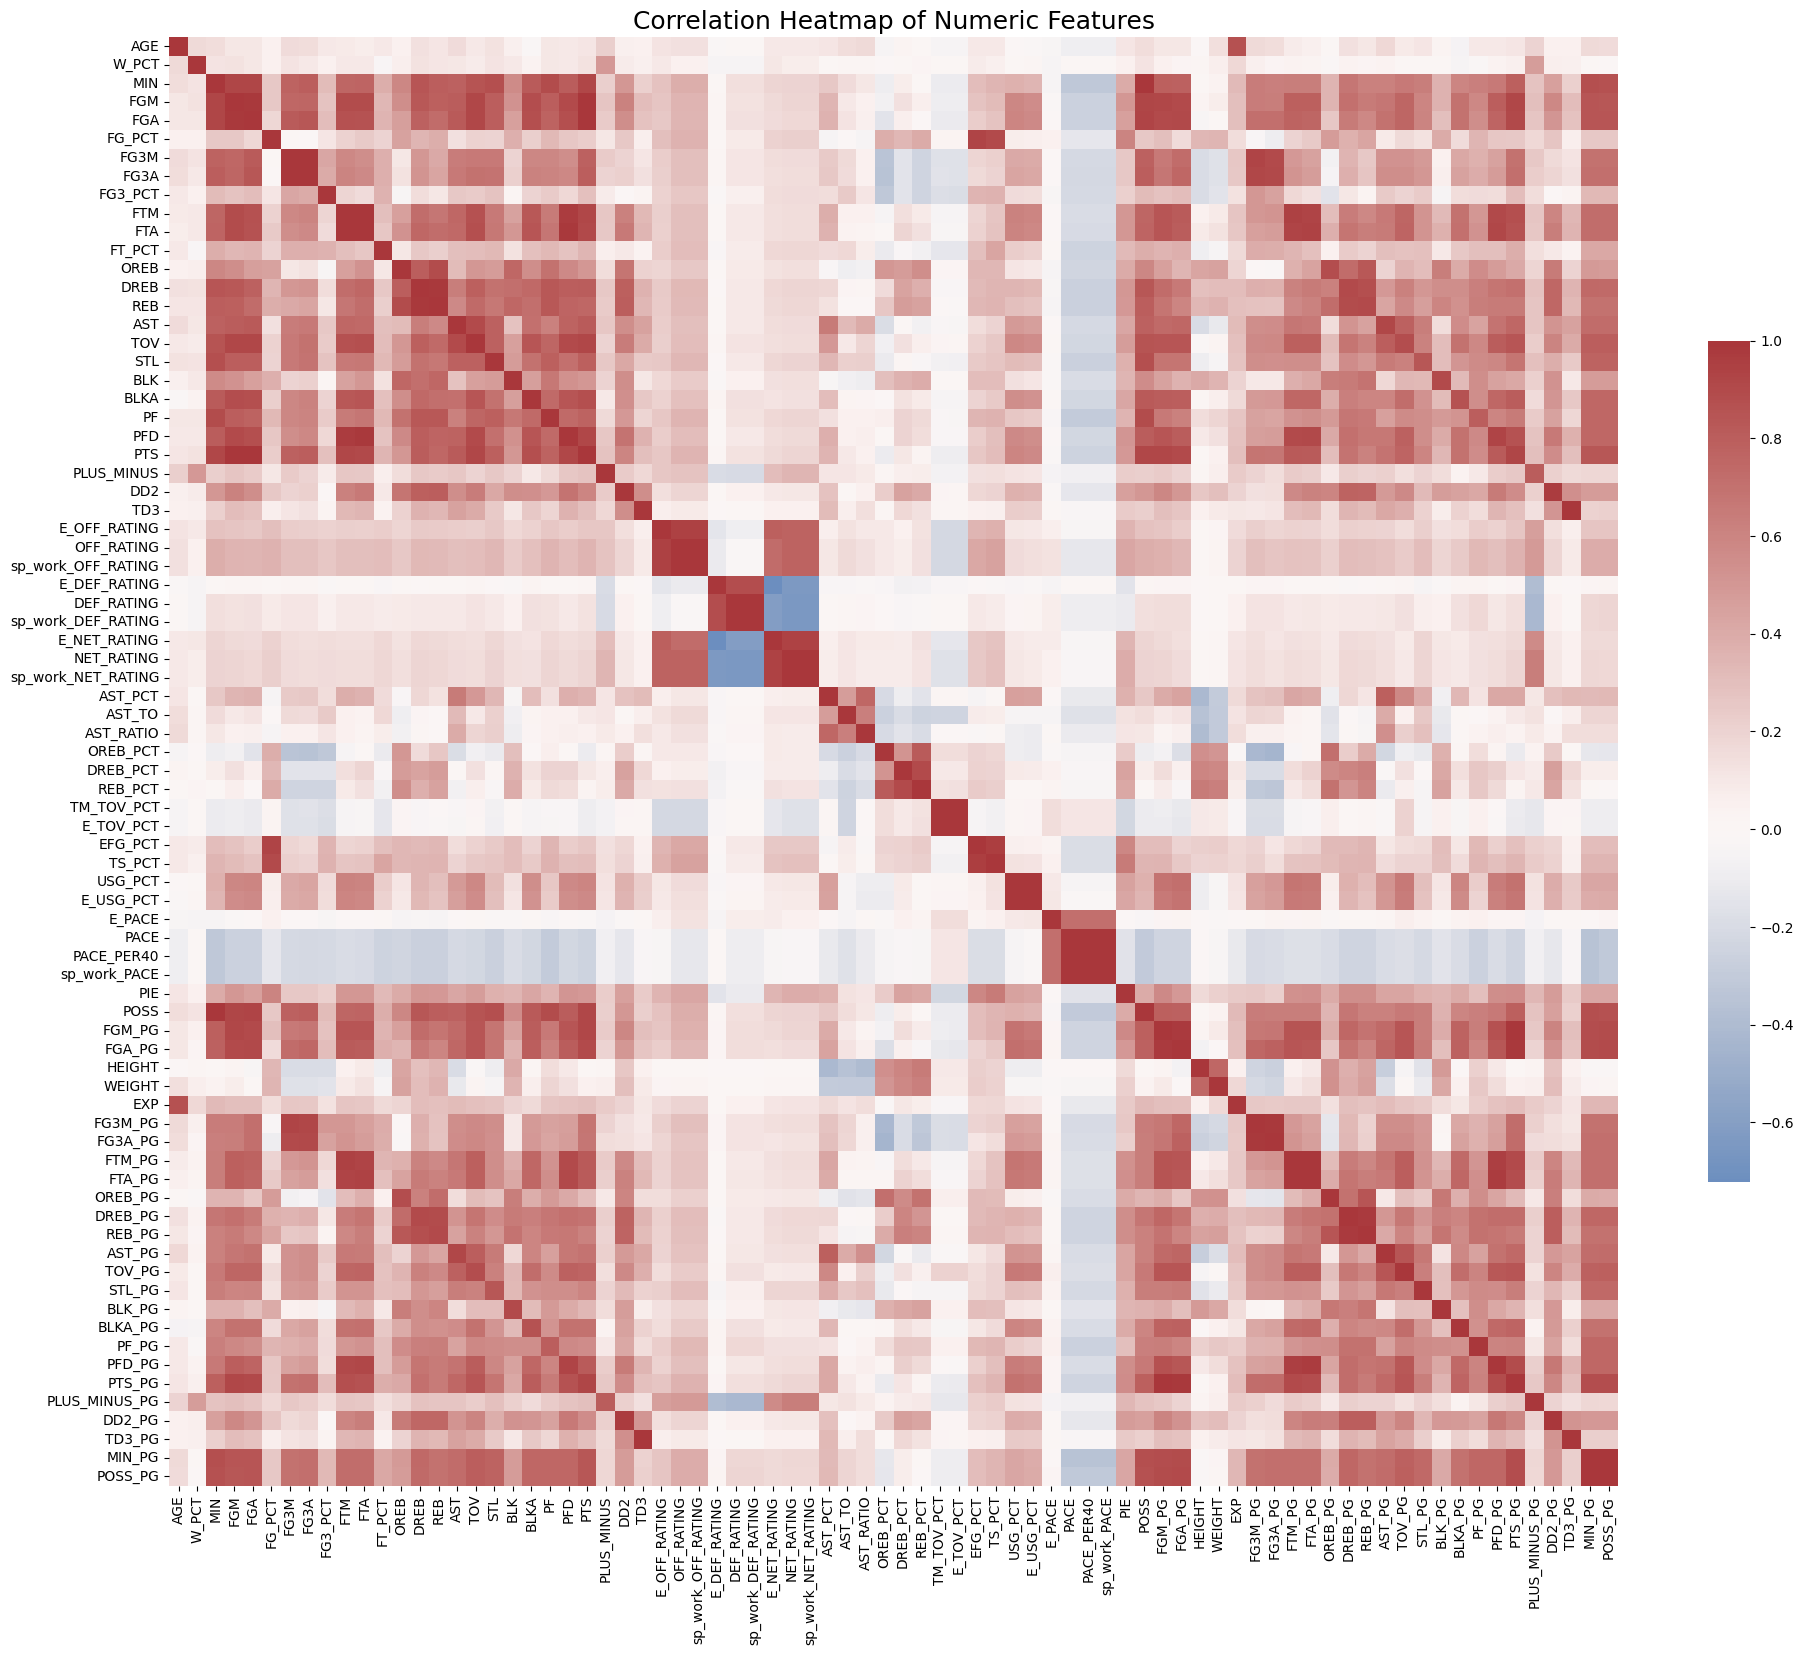

In [37]:
plt.figure(figsize=(20, 18))  # Increase size
sns.heatmap(df_eda[numeric_cols].corr(), 
            cmap='vlag', 
            center=0, 
            annot=False, 
            fmt=".2f", 
            square=True, 
            cbar_kws={"shrink": 0.5})

plt.title("Correlation Heatmap of Numeric Features", fontsize=18)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:


results = {}
for col in numeric_cols:
    X_single = df_eda[[col]].values.reshape(-1, 1)
    
    # Basic Decision Tree
    dt = DecisionTreeRegressor(random_state=42, max_depth=3)
    scores = cross_val_score(dt, X_single, y, cv=5, scoring='r2')  # or 'neg_mean_squared_error'
    results[col] = np.mean(scores)

# Sort by mean R^2
single_feature_importance = pd.Series(results).sort_values(ascending=False)
print("Single-Feature Cross-Validation R^2:")
display(single_feature_importance)

Single-Feature Cross-Validation R^2:


POSS_PG               0.061506
MIN_PG                0.054083
DREB_PG               0.039967
FGM_PG                0.039356
EXP                   0.039241
                        ...   
E_DEF_RATING         -0.030412
E_PACE               -0.030960
PLUS_MINUS_PG        -0.031440
sp_work_DEF_RATING   -0.037564
DEF_RATING           -0.037564
Length: 78, dtype: float64

In [39]:
df_model = pd.get_dummies(df_eda, columns=cat_cols, drop_first=True)

In [40]:
X = df_model.drop(columns=['Games Missed', 'GP', 'W', 'L'], errors='ignore')  # Adjust if you want to drop more columns
y = df['Games Missed']  # Ensure this is numeric

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("Top 20 Feature Importances from the Random Forest:")
display(feature_importances.head(20))

# Evaluate
from sklearn.metrics import r2_score
y_pred = rf.predict(X_test)
print("Random Forest R^2 on test data:", r2_score(y_test, y_pred))

Top 20 Feature Importances from the Random Forest:


POSS             0.157385
MIN_PG           0.095948
POSS_PG          0.079370
MIN              0.044628
EXP              0.038301
PF               0.028613
W_PCT            0.020322
PF_PG            0.017384
PTS_PG           0.016997
STL_PG           0.016444
E_DEF_RATING     0.015276
AST_RATIO        0.014961
E_OFF_RATING     0.013168
WEIGHT           0.012801
FGM_PG           0.012753
FGA_PG           0.012638
PLUS_MINUS_PG    0.012478
TOV              0.011727
AGE              0.011363
BLK_PG           0.010827
dtype: float64

Random Forest R^2 on test data: 0.4190117899728163


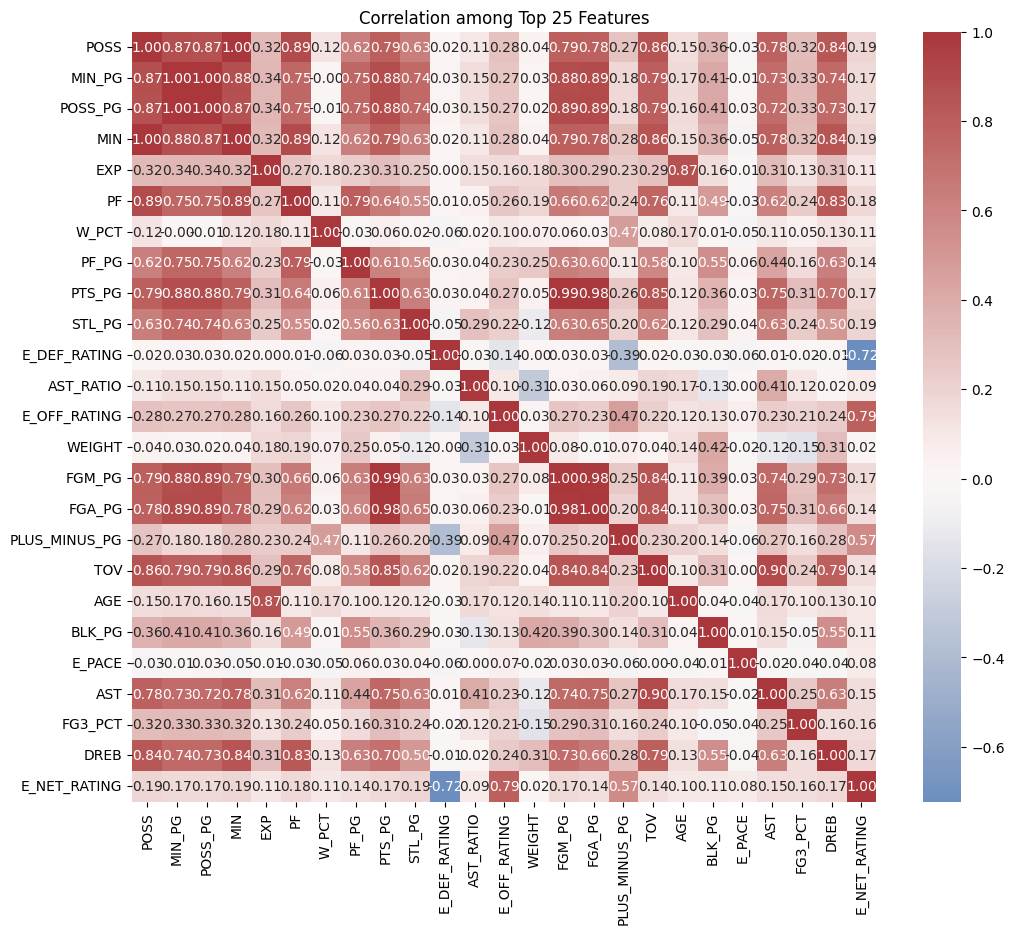

In [41]:
# Example: correlation among top 25 features
top_25_features = feature_importances.head(25).index.tolist()

plt.figure(figsize=(12,10))
sns.heatmap(
    df_model[top_25_features].corr(), 
    cmap='vlag', center=0, annot=True, fmt=".2f"
)
plt.title("Correlation among Top 25 Features")
plt.show()

In [42]:
df_eda.to_csv('nba_data_for_eda.csv', index=False)

In [43]:
df_model = pd.get_dummies(df_eda, columns=cat_cols, drop_first=True)

In [44]:
X = df_model.drop(columns=['Games Missed'], errors='ignore')  # Adjust if you want to drop more columns
y = df['Games Missed']  # Ensure this is numeric

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("Top 20 Feature Importances from the Random Forest:")
display(feature_importances)

# Evaluate
from sklearn.metrics import r2_score
y_pred = rf.predict(X_test)
print("Random Forest R^2 on test data:", r2_score(y_test, y_pred))

Top 20 Feature Importances from the Random Forest:


POSS                       1.573846e-01
MIN_PG                     9.594809e-02
POSS_PG                    7.937004e-02
MIN                        4.462757e-02
EXP                        3.830098e-02
                               ...     
POSITION_Forward           9.975586e-05
TD3                        8.122762e-05
POSITION_Guard/Forward     8.017971e-05
POSITION_Center            8.008679e-05
POSITION_Forward/Center    5.978582e-07
Length: 89, dtype: float64

Random Forest R^2 on test data: 0.4190117899728163


# Export NBA Data for Training with Feature Set 1

In [45]:
df_eda['BMI'] = (703 * df['WEIGHT']) / (df['HEIGHT'] ** 2)

In [46]:
df_eda.columns

Index(['AGE', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV',
       'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'DD2', 'TD3',
       'Games Missed', 'E_OFF_RATING', 'OFF_RATING', 'sp_work_OFF_RATING',
       'E_DEF_RATING', 'DEF_RATING', 'sp_work_DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'sp_work_NET_RATING', 'AST_PCT', 'AST_TO', 'AST_RATIO',
       'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'E_TOV_PCT', 'EFG_PCT',
       'TS_PCT', 'USG_PCT', 'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40',
       'sp_work_PACE', 'PIE', 'POSS', 'FGM_PG', 'FGA_PG', 'HEIGHT', 'WEIGHT',
       'POSITION', 'EXP', 'FG3M_PG', 'FG3A_PG', 'FTM_PG', 'FTA_PG', 'OREB_PG',
       'DREB_PG', 'REB_PG', 'AST_PG', 'TOV_PG', 'STL_PG', 'BLK_PG', 'BLKA_PG',
       'PF_PG', 'PFD_PG', 'PTS_PG', 'PLUS_MINUS_PG', 'DD2_PG', 'TD3_PG',
       'MIN_PG', 'POSS_PG', 'BMI'],
      dtype='object')

In [ ]:
# df_prep_for_Pval=df_prep[['AGE','TEAM_ID','MIN','FGA','FG3M','FG3A','FTM','FTA','OREB','DREB','REB','AST',
#                    'TOV','STL','BLK','BLKA','PF','PFD','PTS','EXP','Games Missed','HEIGHT','WEIGHT']]

In [48]:
df_train = df_eda[['MIN_PG', 'PF_PG', 'STL_PG', 'PTS_PG', 'FGM_PG', 'FGA_PG', 'BLK_PG', 'BLKA_PG', 'PLUS_MINUS_PG', 'PFD_PG', 'TOV_PG', 'DREB_PG', 'REB_PG', 'OREB_PG',
        'FTM_PG', 'FTA_PG', 'POSS_PG', 'EXP', 'POSS', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI', 'USG_PCT', 'PIE', 'E_OFF_RATING', 'E_DEF_RATING', 'AST_TO', 'AST_RATIO', 'FG3M_PG','FG3A_PG', 
        'AST_PG', 'PFD_PG', 'Games Missed']]
df_train.head(5)

,MIN_PG,PF_PG,STL_PG,PTS_PG,FGM_PG,FGA_PG,BLK_PG,BLKA_PG,PLUS_MINUS_PG,PFD_PG,...,PIE,E_OFF_RATING,E_DEF_RATING,AST_TO,AST_RATIO,FG3M_PG,FG3A_PG,AST_PG,PFD_PG,Games Missed
0,7.402381,0.523810,0.238095,3.238095,1.285714,2.880952,0.071429,0.190476,0.428571,0.309524,...,0.076,109.9,106.2,1.43,12.1,0.309524,1.190476,0.476190,0.309524,0
1,10.969315,0.875000,0.160714,4.500000,1.482143,3.500000,0.071429,0.053571,0.892857,0.357143,...,0.068,115.2,111.2,2.50,12.3,1.232143,3.017857,0.535714,0.357143,4
2,8.536500,0.300000,0.050000,2.400000,0.900000,3.100000,0.100000,0.150000,-2.550000,0.050000,...,0.017,106.9,121.7,0.63,6.6,0.500000,1.950000,0.250000,0.050000,25
3,31.463151,1.945205,0.767123,13.876712,5.452055,9.808219,0.616438,0.780822,5.794521,3.054795,...,0.103,118.5,110.4,2.47,21.7,0.547945,1.890411,3.547945,3.054795,9
4,16.273034,1.602564,0.538462,6.589744,2.384615,5.346154,0.076923,0.256410,1.089744,0.833333,...,0.078,111.0,108.0,2.64,22.1,1.076923,2.782051,1.794872,0.833333,0


In [49]:
df_train.columns

Index(['MIN_PG', 'PF_PG', 'STL_PG', 'PTS_PG', 'FGM_PG', 'FGA_PG', 'BLK_PG',
       'BLKA_PG', 'PLUS_MINUS_PG', 'PFD_PG', 'TOV_PG', 'DREB_PG', 'REB_PG',
       'OREB_PG', 'FTM_PG', 'FTA_PG', 'POSS_PG', 'EXP', 'POSS', 'AGE',
       'HEIGHT', 'WEIGHT', 'BMI', 'USG_PCT', 'PIE', 'E_OFF_RATING',
       'E_DEF_RATING', 'AST_TO', 'AST_RATIO', 'FG3M_PG', 'FG3A_PG', 'AST_PG',
       'PFD_PG', 'Games Missed'],
      dtype='object')

In [50]:
df_train.to_csv('data/nba_data_for_train.csv', index=False)

In [25]:
df_train_without_pg = df_eda[['MIN', 'PF', 'STL', 'PTS', 'FGM', 'FGA', 'BLK', 'BLKA', 'PLUS_MINUS', 'PFD', 'TOV', 'DREB', 'REB', 'OREB',
                              'FTM', 'FTA', 'EXP', 'POSS', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI', 'USG_PCT', 'PIE', 'E_OFF_RATING', 'E_DEF_RATING', 
                              'AST_TO', 'AST_RATIO', 'FG3M', 'FG3A', 'AST', 'PFD', 'Games Missed']]

df_train_without_pg.to_csv('data/df_train_without_pg.csv', index=False)

In [2]:
df_eda

NameError: name 'df_eda' is not defined

# Train

In [21]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor